In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad, jacrev
from jax.flatten_util import ravel_pytree
import optax
import matplotlib.pyplot as plt

In [13]:
# ----- Data -----
x = jnp.linspace(-1.0, 1.0, 512)[:, None]          # shape [n, 1]
y = (jnp.sin(4*jnp.pi*x) + 0.8*jnp.sin(16*jnp.pi*x) + 0.6*jnp.sin(64*jnp.pi*x)).squeeze()  # shape [n]

# pick a training subset to speed up NTK computations:
# idx = jnp.arange(0, x.shape[0], 2)
# x_train, y_train = x[idx], y[idx]

# ----- NTK-friendly MLP -----
def init_layer(k, in_dim, out_dim, use_bias=True):
    W = random.normal(k, (in_dim, out_dim)) / jnp.sqrt(in_dim)
    if use_bias:
        b = jnp.zeros((out_dim,))
        return (W, b)
    else:
        return (W,)

def init_mlp(key, widths, use_bias=True):
    keys = random.split(key, len(widths)-1)
    params = []
    for k, (din, dout) in zip(keys, zip(widths[:-1], widths[1:])):
        params.append(init_layer(k, din, dout, use_bias))
    return params

def apply_layer(params, x):
    if len(params) == 2:   # (W, b)
        W, b = params
        return x @ W + b
    else:                  # (W,)
        (W,) = params
        return x @ W

def mlp(params, x):
    # x shape [n, d]
    for (i, layer) in enumerate(params[:-1]):
        x = jnp.tanh(apply_layer(layer, x))
    return apply_layer(params[-1], x).squeeze()  # shape [n]

# Wide net for lazy regime
key = random.PRNGKey(0)
layer_sizes = [1, 4096, 4096, 1]
params0 = init_mlp(key, layer_sizes, use_bias=True)

In [14]:
def mse(params, x, y):
    preds = mlp(params, x)
    return jnp.mean((preds - y)**2)

opt = optax.adam(1e-3)  # small LR encourages lazy behavior
opt_state = opt.init(params0)

@jit
def train_step(params, opt_state, x, y):
    loss, grads = value_and_grad(mse)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [15]:
def jacobian_rows(params, x):
    # returns J of shape [n, P], where P is #parameters flattened
    def f_single(xi):
        # scalar output for a single example
        return mlp(params, xi[None, :]).squeeze()
    # gradient wrt params, flattened
    def grad_flat(xi):
        g = jax.grad(f_single)(xi)
        g_flat, _ = ravel_pytree(g)
        return g_flat
    return vmap(grad_flat)(x)  # [n, P]

def empirical_ntk(params, x1, x2=None):
    if x2 is None:
        J = jacobian_rows(params, x1)        # [n1, P]
        return J @ J.T                        # [n1, n1]
    else:
        J1 = jacobian_rows(params, x1)
        J2 = jacobian_rows(params, x2)
        return J1 @ J2.T

# Initial kernel
K0 = empirical_ntk(params0, x_train)                # [n, n]

# Linearized kernel regression solution at init (ridge lambda for stability)
lam = 1e-6
alpha0 = jnp.linalg.solve(K0 + lam*jnp.eye(K0.shape[0]), y_train)

# For predictions at arbitrary X: K(X, X_train) @ alpha0
def predict_kernel(params_ref, X):
    Kx = empirical_ntk(params_ref, X, x_train)
    return Kx @ alpha0

In [16]:
# Flatten helpers for drift
def flatten_params(p): return ravel_pytree(p)[0]
theta0 = flatten_params(params0)
norm_K0 = jnp.linalg.norm(K0)

# Train + record metrics
num_steps = 3000
log_every = 100

params = params0
losses, ker_drifts, par_drifts, lin_gaps = [], [], [], []

@jit
def preds(params, X): return mlp(params, X)

for step in range(1, num_steps+1):
    params, opt_state, loss = train_step(params, opt_state, x_train, y_train)

    if step % log_every == 0 or step == 1:
        # kernel drift (on train subset)
        Kt = empirical_ntk(params, x_train)
        ker_dr = jnp.linalg.norm(Kt - K0) / (norm_K0 + 1e-12)

        # param drift
        thetat = flatten_params(params)
        par_dr = jnp.linalg.norm(thetat - theta0) / (jnp.linalg.norm(theta0) + 1e-12)

        # linearized vs network predictions (use a held-out grid for clarity)
        y_net = preds(params, x).reshape(-1)
        y_lin = predict_kernel(params0, x)    # linearized with initial NTK
        lin_gap = jnp.linalg.norm(y_net - y_lin) / (jnp.linalg.norm(y_net) + 1e-12)

        losses.append(loss)
        ker_drifts.append(ker_dr)
        par_drifts.append(par_dr)
        lin_gaps.append(lin_gap)

        print(f"step {step:4d} | loss {loss:.3e} | K-drift {ker_dr:.3e} | θ-drift {par_dr:.3e} | lin-gap {lin_gap:.3e}")


step    1 | loss 1.010e+00 | K-drift 1.880e+05 | θ-drift 4.499e-02 | lin-gap 1.000e+00
step  100 | loss 9.733e-01 | K-drift 4.050e+02 | θ-drift 2.178e-01 | lin-gap 2.190e+00
step  200 | loss 8.774e-01 | K-drift 5.530e+02 | θ-drift 2.352e-01 | lin-gap 1.453e+00
step  300 | loss 8.480e-01 | K-drift 7.285e+02 | θ-drift 2.804e-01 | lin-gap 1.356e+00
step  400 | loss 8.298e-01 | K-drift 9.615e+02 | θ-drift 3.109e-01 | lin-gap 1.332e+00
step  500 | loss 8.142e-01 | K-drift 1.234e+03 | θ-drift 3.358e-01 | lin-gap 1.315e+00
step  600 | loss 7.986e-01 | K-drift 1.561e+03 | θ-drift 3.578e-01 | lin-gap 1.296e+00
step  700 | loss 7.817e-01 | K-drift 1.926e+03 | θ-drift 3.769e-01 | lin-gap 1.270e+00
step  800 | loss 7.638e-01 | K-drift 2.317e+03 | θ-drift 3.939e-01 | lin-gap 1.246e+00
step  900 | loss 7.412e-01 | K-drift 2.702e+03 | θ-drift 4.104e-01 | lin-gap 1.233e+00
step 1000 | loss 7.064e-01 | K-drift 3.052e+03 | θ-drift 4.261e-01 | lin-gap 1.229e+00
step 1100 | loss 6.556e-01 | K-drift 3.340e

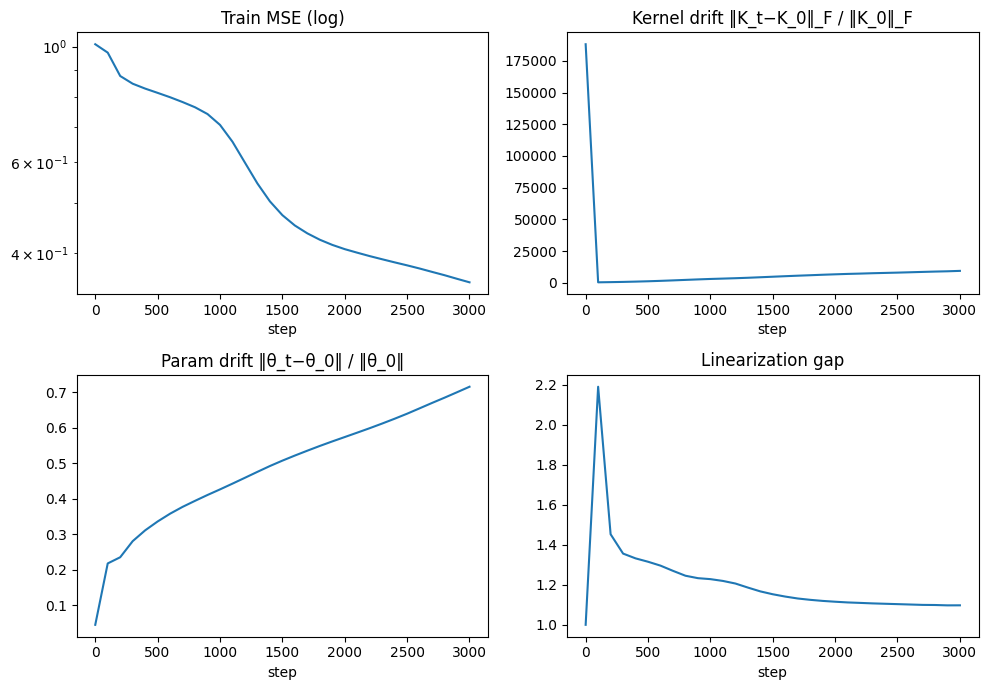

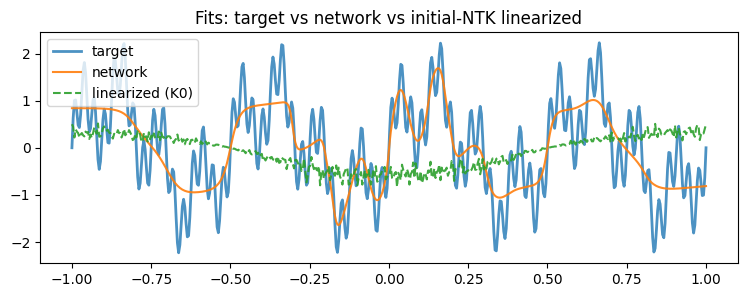

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
axs = axs.ravel()

axs[0].set_title("Train MSE (log)")
axs[0].plot(jnp.arange(len(losses))*log_every + 1, jnp.array(losses))
axs[0].set_yscale('log'); axs[0].set_xlabel("step")

axs[1].set_title("Kernel drift ‖K_t−K_0‖_F / ‖K_0‖_F")
axs[1].plot(jnp.arange(len(ker_drifts))*log_every + 1, jnp.array(ker_drifts))
axs[1].set_xlabel("step")

axs[2].set_title("Param drift ‖θ_t−θ_0‖ / ‖θ_0‖")
axs[2].plot(jnp.arange(len(par_drifts))*log_every + 1, jnp.array(par_drifts))
axs[2].set_xlabel("step")

axs[3].set_title("Linearization gap")
axs[3].plot(jnp.arange(len(lin_gaps))*log_every + 1, jnp.array(lin_gaps))
axs[3].set_xlabel("step")
plt.tight_layout()
plt.show()

# Compare final fits on dense grid
y_net = preds(params, x).reshape(-1)
y_lin = predict_kernel(params0, x)

plt.figure(figsize=(9,3))
plt.plot(x.squeeze(), y, label='target', linewidth=2, alpha=0.8)
plt.plot(x.squeeze(), y_net, label='network', alpha=0.9)
plt.plot(x.squeeze(), y_lin, label='linearized (K0)', alpha=0.9, linestyle='--')
plt.legend(); plt.title("Fits: target vs network vs initial-NTK linearized"); plt.show()
